In [1]:
import numpy as np
import dxchange
import holotomo
import tifffile
import matplotlib.pyplot as plt
import sys
import cupy as cp
PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline


# Init data sizes and parametes of the PXM of ID16A

In [2]:
# cp.cuda.Device(int(sys.argv[1])).use()
# ntheta = int(sys.argv[2])#750  # number of angles (rotations)
# ptheta = int(sys.argv[3])  # holography chunk size for GPU processing
# binning = int(sys.argv[4])
# niter = int(sys.argv[5])
# iter_step = int(sys.argv[6])
# same_probe = sys.argv[7]=='True'
# rand = sys.argv[8]
# shifts_probe_flg = sys.argv[9]=='True'
# st = int(sys.argv[10])

# flg_show = False

cp.cuda.Device(0).use()
ntheta = 300  # number of angles (rotations)
ptheta = 300  # holography chunk size for GPU processing
binning = 0
niter = 33
iter_step = 8
flg_show = True
same_probe = False
rand = 'norand'
shifts_probe_flg = False
flg_show = True

flg = f'{rand}_{ntheta}_{same_probe}'

if shifts_probe_flg==True and rand=='rand':
    shifts_probe = np.array([[0.   ,0.  ], [0.0542, 0.0775], [0.307, 0.4144],[0.7067, 0.67]]).astype('float32')        
elif shifts_probe_flg==True and rand=='norand':
    shifts_probe = np.array([[0.   ,0.  ], [0.07, 0.016], [0.447, 0.291],[0.892, 0.525]]).astype('float32')        
elif shifts_probe_flg==False:
    shifts_probe = None
print(f'{shifts_probe=}')    
    
cropx_left = 512+256
cropx_right = 512+256
cropy_up =0
cropy_down = 1024+512
n = (2048-cropx_left-cropx_right)//2**binning
print(n)
pn = 64  # tomography chunk size for GPU processing

center = n/2  # rotation axis

# ID16a setup
detector_pixelsize = 3e-6
energy = 17.05 #[keV] xray energy
focusToDetectorDistance = 1.2081 # [m]
ndist = 4
sx0 = -2.41e-3
#z1 = np.array([1.5335e-3,1.7065e-3,2.3975e-3,3.8320e-3])[:ndist]-sx0
z1 = np.array([17.723e-3,18.587e-3,22.041e-3,29.215e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2**binning  # object voxel size
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # 
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2
# norm_magnifications[:] = 1

shifts_probe=None
512


In [3]:
pad = True
ne = n*2

## Read data

In [4]:
data0 = np.zeros([ndist,ntheta,n,n],dtype='float32')
ref0 = np.zeros([ndist,n,n],dtype='float32')
dark0 = np.zeros([1,n,n],dtype='float32')

# theta = np.loadtxt(f'/data/viktor/id16a/zysset_s4/zysset_s4_rand_50nm_/angles_file.txt').astype('float32')[:][:1500:1500//ntheta]
# print(f'{theta=}')
for k in range(ndist):
    for j in range(0,ntheta):
        # print(j)
        jtheta=j*1500//ntheta
        print(jtheta)
        fname = f'/data/viktor/id16a/zysset_s4/zysset_s4_{rand}_50nm_{k+1}_/zysset_s4_{rand}_50nm_{k+1}_{jtheta:04}.edf'
        tmp = dxchange.read_edf(fname)[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
        for kb in range(binning):
            tmp = (tmp[::2]+tmp[1::2])/2
            tmp = (tmp[:,::2]+tmp[:,1::2])/2
        data0[k,j] = tmp

    tmp = dxchange.read_edf(f'/data/viktor/id16a/zysset_s4/zysset_s4_{rand}_50nm_{k+1}_/refHST1500.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    for kb in range(binning):
        tmp = (tmp[::2]+tmp[1::2])/2
        tmp = (tmp[:,::2]+tmp[:,1::2])/2
    ref0[k] = tmp

tmp = dxchange.read_edf(f'/data/viktor/id16a/zysset_s4/zysset_s4_{rand}_50nm_1_/dark.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
for kb in range(binning):
    tmp = (tmp[::2]+tmp[1::2])/2
    tmp = (tmp[:,::2]+tmp[:,1::2])/2
dark0[:] = tmp

mean_all = np.mean(data0[:,:,0:n//16,0:n//16])

mean_each = np.mean(data0[:,:,0:n//16,0:n//16],axis=(2,3))
data0 = data0*mean_all/mean_each[:,:,np.newaxis,np.newaxis]

ref0_mean = np.mean(ref0[:,0:n//16,0:n//16],axis=(1,2))
ref0 = ref0*mean_all/ref0_mean[:,np.newaxis,np.newaxis]

data0 = np.sqrt(data0)
ref0 = np.sqrt(ref0)
dark0 = np.sqrt(dark0)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
12

In [5]:

rdata = (data0-dark0[:,np.newaxis])
rref = ref0-dark0
rref[rref<0] = 0
rdata[rdata<0]=0
rdata/=(rref[:,np.newaxis]+1e-9)
for k in range(ndist):
    dxchange.write_tiff(rdata[k],f'/data/viktor/tmp/tn{k}.tiff',overwrite=True)
for k in range(ndist):
    dxchange.write_tiff(data0[k]/ref0[k],f'/data/viktor/tmp/dn{k}.tiff',overwrite=True)

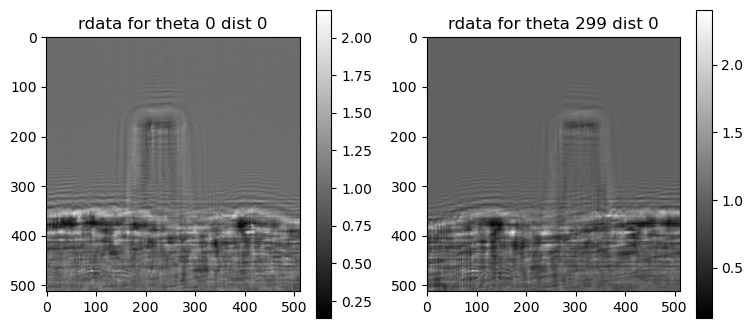

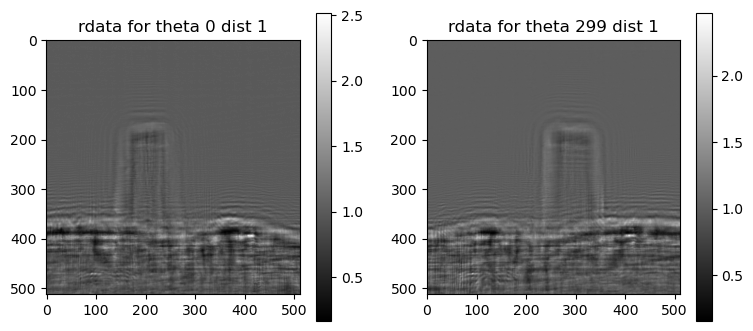

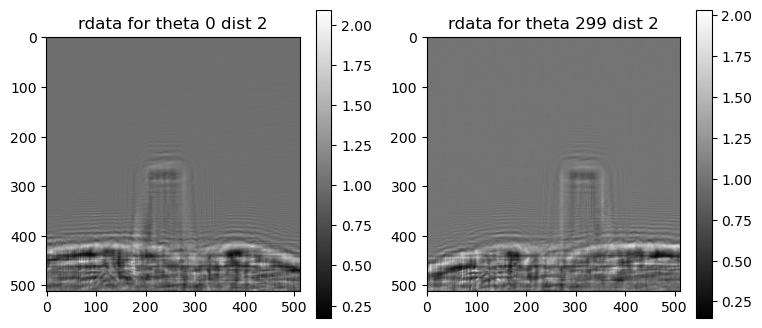

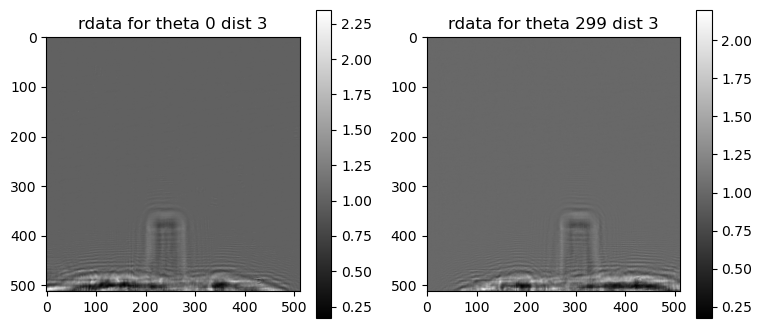

In [6]:
if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 2, figsize=(9, 4))
        im=axs[0].imshow(rdata[k,0],cmap='gray')
        axs[0].set_title(f'rdata for theta 0 dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata[k,-1],cmap='gray')
        axs[1].set_title(f'rdata for theta {ntheta-1} dist {k}')
        fig.colorbar(im)

In [7]:

shifts_random = np.zeros([ndist,ntheta,2],dtype='float32')
for k in range(ndist):
    if rand=='rand':
        s = np.loadtxt(f'/data/viktor/id16a/zysset_s4/zysset_s4_{rand}_50nm_{k+1}_/correct.txt').astype('float32')[::1500//ntheta]/norm_magnifications[k]
    else:
        s = np.zeros([ntheta,2],dtype='float32')#np.loadtxt(f'/data/viktor/id16a/zysset_s4/zysset_s4_norand_50nm_{k+1}_/correct.txt').astype('float32')[:1500:1500//ntheta]/norm_magnifications[k]    
    shifts_random[k,:,0] = s[:,1]+(1024-(2048-cropy_down)/2)*(1/norm_magnifications[k]-1)#/norm_magnifications[k]
    shifts_random[k,:,1] = s[:,0]

# shifts_dist = np.zeros([ndist,ntheta,2],dtype='float32')
# rdata_shifted=rdata.copy()
# rdata_scaled=rdata.copy()
# for j in range(ntheta):
#     for k in range(0,ndist):#!!!!!!!!!!!!!!
#         rdata_shifted[k,j:j+1] = apply_shift(rdata[k,j:j+1],-shifts_random[k,j:j+1]/2**binning*norm_magnifications[k])# note first shift then magnification    
#         a = ndimage.zoom(rdata_shifted[k,j],1/norm_magnifications[k])
#         rdata_scaled[k,j] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]        
#         shifts_dist[k,j] = registration_shift(rdata_scaled[k,j:j+1],rdata_scaled[0,j:j+1],upsample_factor=10)
#         print(f'{k} {j}: {shifts_random[k,j:j+1]/2**binning} {shifts_dist[k,j]}')

import scipy.io 
shifts_new = -scipy.io.loadmat(f'/data/viktor/id16a/zysset_s4/zysset_s4_{rand}_50nm_/rhapp_py.mat')['rhapp'][:,:,:1500].swapaxes(0,2).swapaxes(0,1)[:ndist,::1500//ntheta]

print(shifts_new.shape)
shifts_new+=shifts_random
shifts_new/=2**binning
# shifts_new*=norm_magnifications[:,np.newaxis,np.newaxis]


# shifts = (shifts_dist+shifts_random/2**binning)#*norm_magnifications[:,np.newaxis,np.newaxis]# cannot be combined with 

# if flg_show:
#     for k in range(ndist):
#         plt.figure()
#         plt.plot(shifts[k,:,1],'rx')
#         plt.plot(shifts_new[k,:,1],'bo')

# take shifts from Peter
shifts = shifts_new

  

(4, 300, 2)


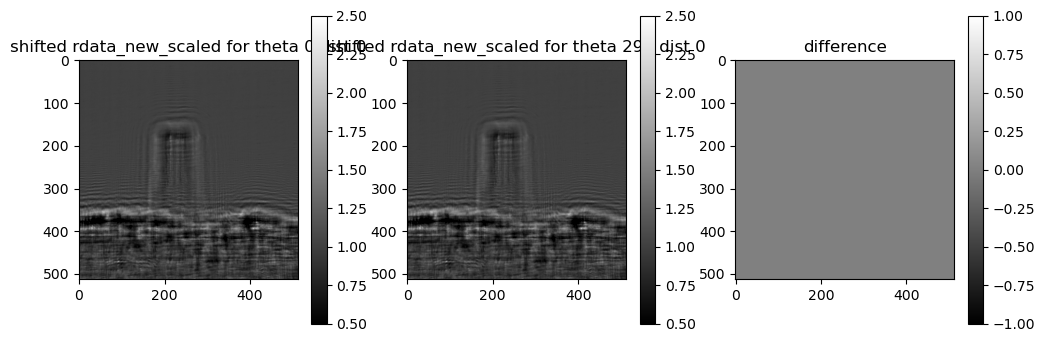

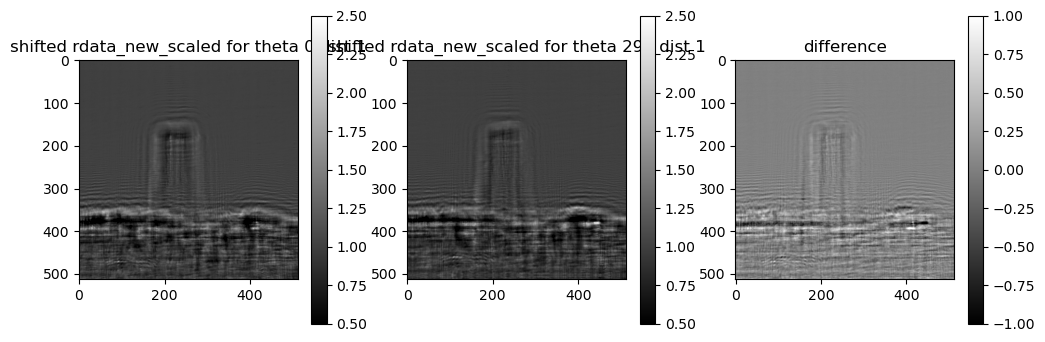

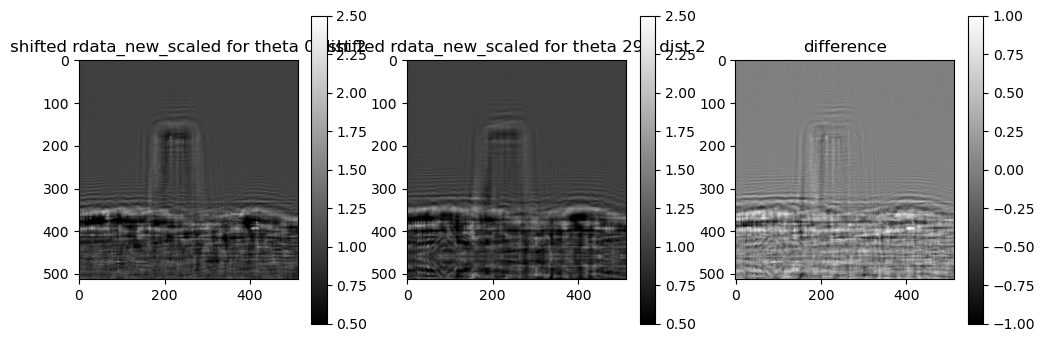

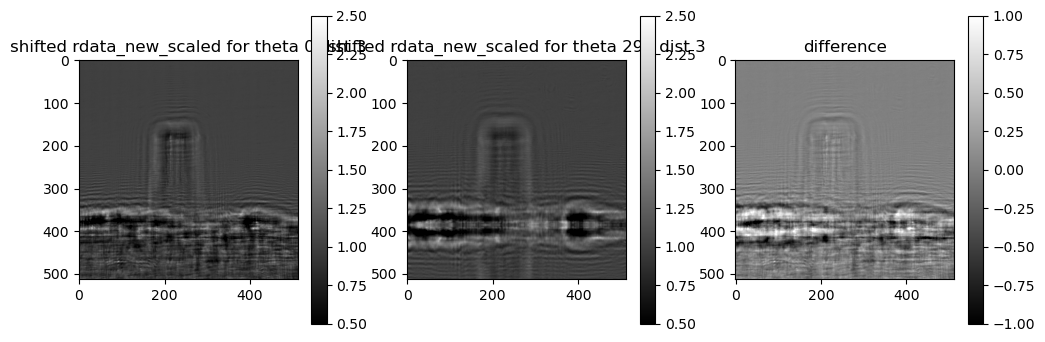

In [8]:
import scipy.ndimage as ndimage
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res
rdata_scaled_new = rdata.copy()
for j in range(ntheta):
    
    for k in range(ndist):    
        a = apply_shift(rdata[k,j:j+1],-shifts[k,j:j+1]*norm_magnifications[k,np.newaxis,np.newaxis])[0]# note first shift then magnification
        a = ndimage.zoom(a,1/norm_magnifications[k])
        rdata_scaled_new[k,j] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]  

if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        im=axs[0].imshow(rdata_scaled_new[0,0],cmap='gray',vmin = 0.5,vmax=2.5 )
        axs[0].set_title(f'shifted rdata_new_scaled for theta 0 dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata_scaled_new[k,0],cmap='gray',vmin = 0.5,vmax=2.5 )
        axs[1].set_title(f'shifted rdata_new_scaled for theta {ntheta-1} dist {k}')
        fig.colorbar(im)        
        im=axs[2].imshow(rdata_scaled_new[0,0]-rdata_scaled_new[k,0],cmap='gray',vmin =-1,vmax=1 )
        axs[2].set_title(f'difference')
        fig.colorbar(im)     
dxchange.write_tiff(rdata_scaled_new,'/data/vnikitin/holo/tmp/r',overwrite=True)     
    

## Create a solver class for holography, note the class has additional parameters distances2 to be able to compute Fresnel propagation between the sample and probe

In [9]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distances2,pad=pad,same_probe=same_probe)
pslv0 = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances, norm_magnifications, distances2,pad=pad,same_probe=same_probe)


In [10]:
data = data0.copy()
ref = ref0.copy()
arr1 = np.pad(np.array(data[0]+1j*data[0]).astype('complex64'),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')

prb1 = np.array(ref[:]+1j*ref[:]).astype('complex64')
arr2 = pslv.fwd_holo_batch(arr1, prb1)
arr3 = pslv.adj_holo_batch(arr2, prb1)
prb3 = pslv.adj_holo_prb_batch(arr2,arr1)



print(np.sum(arr1*np.conj(arr3)))
print(np.sum(arr2*np.conj(arr2)))
print(np.sum(prb1*np.conj(prb3)))

(9208436000000000+1236648j)
(9208366000000000+3277.996j)
(9208417000000000-21233664j)


## Conjugate gradient solver

In [11]:
import cupy as cp
def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def cg_holo(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts, code=None, shifts_code=None, upd_psi=True, upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-data)**2            
        f += cp.linalg.norm(cp.abs(fprb)-data_ref)**2        
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    shifts_code_nil = shifts_code[:,:1]*0
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)          
            d = -pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb,shifts,code, shifts_code)/cp.max(cp.abs(prb))**2#/ndist**2

            fd = pslv.fwd_holo(d, prb,shifts,code, shifts_code)     
            gammapsi = line_search(minf, gammapsi0, fpsi, 0, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil, code, shifts_code_nil)
            dprb = pslv.adj_holo_prb(fprb-data*cp.exp(1j*cp.angle(fprb)),psi,shifts,code, shifts_code)#/ndist**2
            dprb += pslv0.adj_holo_prb(fprb0-data_ref*cp.exp(1j*cp.angle(fprb0)),psi_nil,shifts_nil,code, shifts_code_nil)
            dprb*=-1/(pslv.ntheta+1)

            # line search
            fdprb = pslv.fwd_holo(psi, dprb,shifts,code, shifts_code)
            fdprb0 = pslv0.fwd_holo(psi_nil, dprb,shifts_nil,code, shifts_code_nil)
            
            gammaprb = line_search(minf, gammaprb0, fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        if i%step==0:
            fprb = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil,code, shifts_code_nil)            
            err=minf(fprb,fprb0)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}', flush=True)  

        if upd_prb==True and upd_psi==False and i%vis_step==0:  
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(cp.abs(prb[0]).get(),cmap='gray')
            axs[0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[1].imshow(cp.angle(prb[0]).get(),cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)                
            plt.show()
        elif i%vis_step==0:  
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(cp.abs(psi[0]).get(),cmap='gray')
            axs[0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[1].imshow(cp.angle(psi[0]).get(),cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)                
            plt.show()
            dxchange.write_tiff(cp.angle(psi).get(),f'/data/vnikitin/holo/zysset{flg}/{n}_{ntheta}_{ndist}/r{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/holo/zysset{flg}/{n}_{ntheta}_{ndist}/o{i:05}.tiff',overwrite=True)
                        
            
    return psi,prb

def cg_holo_batch(pslv, pslv0, data,data_ref, init, prb_init, piter,shifts=None,code=None, shifts_code=None,upd_psi=True,upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                
    codes_gpu = cp.array(code)
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        data_ref_gpu = cp.array(data_ref)
        
        init_gpu = cp.array(init[ids])
        shifts_gpu = cp.array(shifts[:,ids])        
        shift_codes_gpu = cp.array(shifts_code[:,ids])
        
        # Radon transform
        res_gpu,res_prb_gpu = cg_holo(pslv, pslv0, data_gpu,data_ref_gpu, init_gpu,prb_init_gpu, piter,shifts_gpu,codes_gpu,shift_codes_gpu,upd_psi, upd_prb,step,vis_step,gammapsi0,gammaprb0)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb


def adj_holo_batch_ext(pslv,fpsi, data, prb, shifts=None, code=None, shifts_code=None,shifts_probe=None):
    """Batch of Holography transforms"""
    res = np.zeros([ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_gpu = cp.array(prb)
    shifts_gpu = None        
    shifts_code_gpu = None
    code_gpu = None
    shifts_probe_gpu = None
    if code is not None:
        code_gpu = cp.array(code)   
    if shifts_probe is not None:
        shifts_probe_gpu = cp.array(shifts_probe)
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        fpsi_gpu = cp.array(fpsi[:, ids])
        data_gpu = cp.array(data[:, ids])
            
        if shifts is not None:
            shifts_gpu = cp.array(shifts[:,ids])
        if shifts_code is not None:
            shifts_code_gpu = cp.array(shifts_code[:,ids])
        fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(np.angle(fpsi_gpu)))        
        # Radon transform
        res_gpu = -pslv.adj_holo(fpsi_gpu, prb_gpu, shifts_gpu, code_gpu, shifts_code_gpu,shifts_probe_gpu)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res

def adj_holo_prb_batch_ext(pslv, fpsi, data, psi, shifts=None, code=None, shifts_code=None,shifts_probe=None):
        """Batch of Holography transforms"""
        res = np.zeros([len(pslv.distances), pslv.n, pslv.n], dtype='complex64')
        shifts_gpu = None        
        shifts_code_gpu = None
        code_gpu = None
        shifts_probe_gpu = None
        if code is not None:
            code_gpu = cp.array(code)   
        if shifts_probe is not None:
            shifts_probe_gpu = cp.array(shifts_probe)
        for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
            # copy data part to gpu
            fpsi_gpu = cp.array(fpsi[:, ids])
            psi_gpu = cp.array(psi[ids])
            data_gpu = cp.array(data[:, ids])
            
            if shifts is not None:
                shifts_gpu = cp.array(shifts[:,ids])
            if shifts_code is not None:
                shifts_code_gpu = cp.array(shifts_code[:,ids])
            # Radon transform
            fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(np.angle(fpsi_gpu)))                
            # fprb-data*np.exp(1j*np.angle(fprb))
            res_gpu = -pslv.adj_holo_prb(fpsi_gpu, psi_gpu, shifts_gpu,code_gpu,shifts_code_gpu,shifts_probe_gpu)
            # copy result to cpu
            res += res_gpu.get()
        return res

def cg_holo_batch2(pslv, pslv0, data,data_ref, init, prb_init, piter,  \
                      shifts=None,code=None, shifts_code=None,upd_psi=True,upd_prb=True,\
                        step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(fpsi,fprb):
        f = np.linalg.norm(np.abs(fpsi)-data)**2            
        f += np.linalg.norm(np.abs(fprb)-data_ref)**2        
        return f        
    
    psi = init.copy()
    prb = prb_init.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    
    
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0+1
    shifts_code_nil = shifts_code[:,0:1]*0
    
    for i in range(piter):
        if upd_psi:
            fpsi = pslv.fwd_holo_batch(psi,prb,shifts,code,shifts_code)          
            d = adj_holo_batch_ext(pslv,fpsi,data, prb,shifts,code,shifts_code)/np.max(np.abs(prb))**2
            
            # line search
            fd = pslv.fwd_holo_batch(d, prb,shifts,code,shifts_code)             
            gammapsi = line_search(minf, gammapsi0, fpsi, 0, fd, 0)       
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo_batch(psi,prb,shifts,code,shifts_code)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil,code,shifts_code_nil)            
            dprb = adj_holo_prb_batch_ext(pslv,fprb,data,psi,shifts,code,shifts_code)#/ndist**2            
            dprb += adj_holo_prb_batch_ext(pslv0,fprb0,data_ref,psi_nil,shifts_nil,code,shifts_code_nil)
            dprb *= 1/(pslv.ntheta+1)

            # line search
            fdprb = pslv.fwd_holo_batch(psi, dprb,shifts,code,shifts_code) 
            fdprb0 = pslv0.fwd_holo_batch(psi_nil, dprb,shifts_nil,code,shifts_code_nil) 
            
            gammaprb = line_search(minf, gammaprb0, fprb, fprb0, fdprb, fdprb0)
            
            prb = prb + gammaprb*dprb                    
        if i%step==0:
            fprb = pslv.fwd_holo_batch(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil,code, shifts_code_nil)            
            err=minf(fprb,fprb0)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}', flush=True)  
        if i%vis_step==0:  
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
            axs[0].set_title('reconstructed abs')
            fig.colorbar(im)
            im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)                
            plt.show()
    return psi,prb

In [12]:
code = np.ones([1,2*n,2*n],dtype='complex64')
shifts_code = np.zeros([ndist,ntheta,2],dtype='float32')

0) gammapsi=0.5 gammaprb=1, err=2.86099e-03


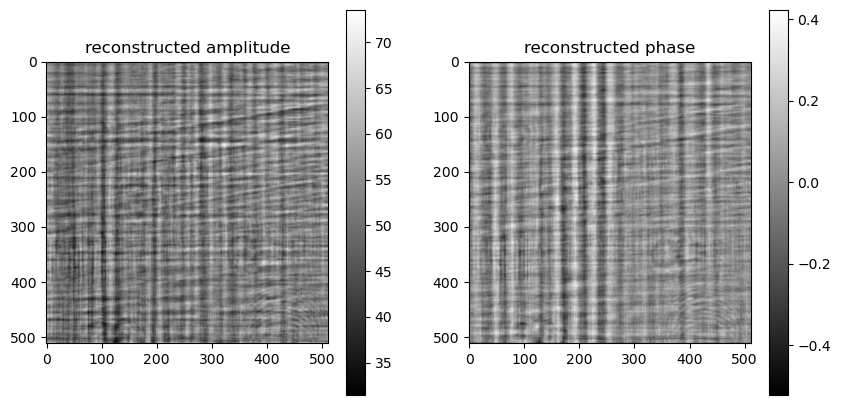

16) gammapsi=0.5 gammaprb=1, err=2.30327e-04
32) gammapsi=0.5 gammaprb=1, err=2.68636e-04


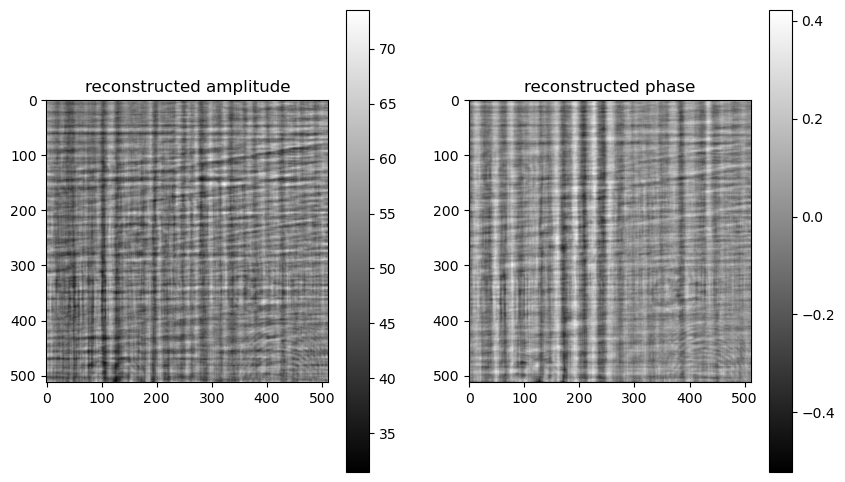

In [13]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distances2,pad=pad,same_probe=same_probe)
pslv0 = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances, norm_magnifications, distances2,pad=pad,same_probe=same_probe)

rec = np.ones([1,ne,ne],dtype='complex64')
rec_prb = np.ones([ndist,n,n],dtype='complex64')        
data_ref = ref[:,np.newaxis]
shifts_ref = np.array(shifts)[:,:1]*0
shifts_codes_ref = np.array(shifts_code)[:,:1]*0
_,rec_prb0 = cg_holo_batch(pslv0, pslv0, data_ref, data_ref, rec, rec_prb, 33, shifts_ref, code, shifts_codes_ref, False,True,16,35,0.5,1)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
im=axs[0].imshow(np.abs(rec_prb0[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec_prb0[0]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)

In [14]:
shifts_rec = cp.array(shifts/norm_magnifications[:,np.newaxis,np.newaxis])
rec1 = np.ones([ntheta,ne,ne],dtype='complex64')
# # use only the abs value of the probe as initial guess
rec_prb1 = rec_prb0.copy()
# rec1,rec_prb1 = cg_holo_batch(pslv, pslv0, data, data_ref, rec1, rec_prb1, 65, shifts_rec, code, shifts_code, True,True,4,16,0.5,1)


In [15]:
def line_search_ext(minf, gamma, u, fu, fu0, d, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(u,fu,fu0)-minf(u+gamma*d, fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def line_search(minf, gamma, u, fu, d, fd):

    """ Line search for the step sizes gamma"""

    while(minf(u, fu)-minf(u+gamma*d, fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def cg_holo_ext(pslv, pslv0, data, data_ref, init, init_prb,  piter, h, lamd, rho, \
                shifts=None, code=None, shifts_code=None, upd_psi=True, upd_prb=False,\
                step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(psi,fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-data)**2            
        f += cp.linalg.norm(cp.abs(fprb)-data_ref)**2      
        f += rho*cp.linalg.norm(h-psi+lamd/rho)**2        
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    shifts_code_nil = shifts_code[:,0:1]*0
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)          
            d = -pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb,shifts,code, shifts_code)/cp.max(cp.abs(prb))**2#/ndist**2
            d += rho*(h - psi + lamd/rho)

            # fd = pslv.fwd_holo(d, prb,shifts,code, shifts_code)     
            gammapsi = gammapsi0#line_search_ext(minf, gammapsi0, psi, fpsi, 0, d, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil, code, shifts_code_nil)
            dprb = pslv.adj_holo_prb(fprb-data*cp.exp(1j*cp.angle(fprb)),psi,shifts,code, shifts_code)#/ndist**2
            dprb += pslv0.adj_holo_prb(fprb0-data_ref*cp.exp(1j*cp.angle(fprb0)),psi_nil,shifts_nil,code, shifts_code_nil)
            dprb*=-1/(pslv.ntheta+1)

            # line search
            # fdprb = pslv.fwd_holo(psi, dprb,shifts,code, shifts_code)
            # fdprb0 = pslv0.fwd_holo(psi_nil, dprb,shifts_nil,code, shifts_code_nil)
            
            #PLEASE CHECK!!!
            gammaprb = gammaprb0#line_search_ext(minf, gammaprb0, psi, fprb, fprb0, 0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        # if i%step==0:
        #     fprb = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)
        #     fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil,code, shifts_code_nil)            
        #     err=minf(psi,fprb,fprb0)
        #     print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}', flush=True)                                    
    
    return psi,prb

def cg_holo_batch_ext(pslv, pslv0, data,data_ref, init, prb_init, piter, h, lamd, rho, \
                      shifts=None,code=None, shifts_code=None,upd_psi=True,upd_prb=False,\
                        step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                
    codes_gpu = cp.array(code)
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        data_ref_gpu = cp.array(data_ref)
        
        init_gpu = cp.array(init[ids])
        h_gpu = cp.array(h[ids])
        lamd_gpu = cp.array(lamd[ids])
        shifts_gpu = cp.array(shifts[:,ids])        
        shift_codes_gpu = cp.array(shifts_code[:,ids])
        
        # Radon transform
        res_gpu,res_prb_gpu = cg_holo_ext(pslv, pslv0, data_gpu,data_ref_gpu, init_gpu,prb_init_gpu, piter,h_gpu, lamd_gpu, rho, \
                                      shifts_gpu,codes_gpu,shift_codes_gpu,upd_psi, upd_prb,step,vis_step,gammapsi0,gammaprb0)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb


def adj_holo_batch_ext(pslv,fpsi, data, prb, shifts=None, code=None, shifts_code=None,shifts_probe=None):
    """Batch of Holography transforms"""
    res = np.zeros([ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_gpu = cp.array(prb)
    shifts_gpu = None        
    shifts_code_gpu = None
    code_gpu = None
    shifts_probe_gpu = None
    if code is not None:
        code_gpu = cp.array(code)   
    if shifts_probe is not None:
        shifts_probe_gpu = cp.array(shifts_probe)
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        fpsi_gpu = cp.array(fpsi[:, ids])
        data_gpu = cp.array(data[:, ids])
            
        if shifts is not None:
            shifts_gpu = cp.array(shifts[:,ids])
        if shifts_code is not None:
            shifts_code_gpu = cp.array(shifts_code[:,ids])
        fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(np.angle(fpsi_gpu)))        
        # Radon transform
        res_gpu = -pslv.adj_holo(fpsi_gpu, prb_gpu, shifts_gpu, code_gpu, shifts_code_gpu,shifts_probe_gpu)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res

def adj_holo_prb_batch_ext(pslv, fpsi, data, psi, shifts=None, code=None, shifts_code=None,shifts_probe=None):
        """Batch of Holography transforms"""
        res = np.zeros([len(pslv.distances), pslv.n, pslv.n], dtype='complex64')
        shifts_gpu = None        
        shifts_code_gpu = None
        code_gpu = None
        shifts_probe_gpu = None
        if code is not None:
            code_gpu = cp.array(code)   
        if shifts_probe is not None:
            shifts_probe_gpu = cp.array(shifts_probe)
        for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
            # copy data part to gpu
            fpsi_gpu = cp.array(fpsi[:, ids])
            psi_gpu = cp.array(psi[ids])
            data_gpu = cp.array(data[:, ids])
            
            if shifts is not None:
                shifts_gpu = cp.array(shifts[:,ids])
            if shifts_code is not None:
                shifts_code_gpu = cp.array(shifts_code[:,ids])
            fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(np.angle(fpsi_gpu)))                
            res_gpu = -pslv.adj_holo_prb(fpsi_gpu, psi_gpu, shifts_gpu,code_gpu,shifts_code_gpu,shifts_probe_gpu)
            # copy result to cpu
            res += res_gpu.get()
        return res

def cg_holo_batch2_ext(pslv, pslv0, data,data_ref, init, prb_init, piter, h, lamd, rho, \
                      shifts=None,code=None, shifts_code=None,upd_psi=True,upd_prb=False,\
                        step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(psi,fpsi,fprb):
        f = np.linalg.norm(np.abs(fpsi)-data)**2            
        f += np.linalg.norm(np.abs(fprb)-data_ref)**2        
        f += rho*np.linalg.norm(h-psi+lamd/rho)**2     
        return f        
    
    psi = init.copy()
    prb = prb_init.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    
    
    psi_nil = psi*0+1
    shifts_nil = shifts*0+1
    shifts_code_nil = shifts_code[:,0:1]*0
    
    for i in range(piter):
        if upd_psi:
            fpsi = pslv.fwd_holo_batch(psi,prb,shifts,code,shifts_code)          
            d = adj_holo_batch_ext(pslv,fpsi,data, prb,shifts,code,shifts_code)/np.max(np.abs(prb))**2
            d += rho*(h - psi + lamd/rho)
         
            # line search
            #fd = pslv.fwd_holo_batch(d, prb,shifts,code,shifts_code)             
            gammapsi = gammapsi0#line_search_ext(minf, gammapsi0, psi, fpsi, 0, d, fd, 0)       
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo_batch(psi,prb,shifts,code,shifts_code)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil,code,shifts_code_nil)            
            dprb = adj_holo_prb_batch_ext(pslv,fprb,data,psi,shifts,code,shifts_code)#/ndist**2            
            dprb += adj_holo_prb_batch_ext(pslv0,fprb0,data_ref,psi_nil,shifts_nil,code,shifts_code_nil)
            dprb *= 1/(pslv.ntheta+1)

            # line search
            #fdprb = pslv.fwd_holo_batch(psi, dprb,shifts,code,shifts_code) 
            #fdprb0 = pslv0.fwd_holo_batch(psi_nil, dprb,shifts_nil,code,shifts_code_nil) 
            
            gammaprb = gammaprb0#line_search_ext(minf, gammaprb0, psi, fprb, fprb0, 0, fdprb, fdprb0)
            
            prb = prb + gammaprb*dprb                    
                   
    return psi,prb

def take_lagr(pslv,pslv0, psi,prb, data, data_ref,shifts, code, shifts_code, h, lamd,rho):
    lagr = np.zeros(5, dtype="float32")

    fpsi = pslv.fwd_holo_batch(psi,prb,shifts, code, shifts_code)    
    lagr[0] = np.linalg.norm(np.abs(fpsi)-data)**2            

    psi_nil = psi*0+1
    shifts_nil = shifts*0
    shifts_code_nil = shifts_code[:,0:1]*0
    fprb = pslv0.fwd_holo_batch(psi_nil,prb, shifts_nil, code, shifts_code_nil)            
    lagr[1] = np.linalg.norm(np.abs(fprb)-data_ref)**2      

    lagr[2] = 2*np.sum(np.real(np.conj(lamd)*(h-psi)))
    
    lagr[3] = rho*cp.linalg.norm(h-psi)**2    

    lagr[4] = cp.sum(lagr[0:4])

    return lagr
def take_lagr_gpu(pslv,pslv0, psi, prb, data, data_ref, shifts, code, shifts_code, h, lamd,rho):
    lagr = cp.zeros(5, dtype="float32")
    fpsi = pslv.fwd_holo(psi,prb,shifts, code, shifts_code)    
    lagr[0] = cp.linalg.norm(np.abs(fpsi)-data)**2            

    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    shifts_code_nil = shifts_code[:,0:1]*0
    fprb = pslv0.fwd_holo(psi_nil,prb, shifts_nil, code, shifts_code_nil)            
    lagr[1] = cp.linalg.norm(cp.abs(fprb)-data_ref)**2      

    lagr[2] = 2*cp.sum(cp.real(cp.conj(lamd)*(h-psi)))
    
    lagr[3] = rho*cp.linalg.norm(h-psi)**2    

    lagr[4] = cp.sum(lagr[0:4])

    return lagr

def update_penalty(psi, h, h0, rho):
    # rho
    r = np.linalg.norm(psi - h)**2
    s = np.linalg.norm(rho*(h-h0))**2
    if (r > 10*s):
        rho *= 2
    elif (s > 10*r):
        rho *= 0.5
    
    return rho
def admm(pslv, pslv0, tslv, data,data_ref, h, psi, prb, shifts, code, shifts_code, lamd, u, piter, titer, niter,step=1,viz_step=1):
    rho = 0.5
    for m in range(niter):
        # keep previous iteration for penalty updates
        # h0 = h.copy()
        psi,prb = cg_holo_batch2_ext(pslv, pslv0, data, data_ref, psi, prb, piter,h, lamd,rho,\
                                shifts,code,shifts_code,True,True,1,1,0.5,1)
                                #1,1,1,2)
        xi = pslv.logtomo(psi-lamd/rho)
        # tomography problem
        u = tslv.cg_tomo_batch(xi, u, titer, 0.5)
        # h,e updates        
        h = pslv.exptomo(tslv.fwd_tomo_batch(u))
        # lambda, mu updates
        lamd = lamd + rho * (h-psi)
                
        if m%viz_step==0:
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(np.real(u[:,ne//2]), cmap='gray')
            axs[0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[1].imshow(np.angle(psi[0]), cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)                
            plt.show()
            dxchange.write_tiff(np.angle(psi),   f'/data/vnikitin/holo/zysset_s4/{flg}/psi/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.angle(psi[0]),f'/data/vnikitin/holo/zysset_s4/{flg}/psi/o{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.imag(u),      f'/data/vnikitin/holo/zysset_s4/{flg}/uim/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.imag(u[550]), f'/data/vnikitin/holo/zysset_s4/{flg}/uim/o{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.real(u),      f'/data/vnikitin/holo/zysset_s4/{flg}/ure/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.real(u[550]), f'/data/vnikitin/holo/zysset_s4/{flg}/ure/o{m:05}.tiff',overwrite=True)
        # Lagrangians difference between two iterations
        if m%step==0:
            lagr = take_lagr(pslv,pslv0, psi,prb, data, data_ref,shifts, code,shifts_code, h, lamd,rho)
            print("%d/%d) rho=%f, %.2e %.2e %.2e %.2e, Sum: %.2e" %(m, niter, rho, *lagr),flush=True)
        
        # rho = update_penalty(psi,h,h0,rho)
    return u, psi, prb
def admm_gpu(pslv, pslv0, tslv, data,data_ref, h, psi, prb,shifts, code, shifts_code, lamd, u, piter, titer, niter,step=1,viz_step=1):
    rho = 0.5    
    for m in range(niter):
        # keep previous iteration for penalty updates
        # h0 = h.copy()
        psi,prb = cg_holo_ext(pslv, pslv0, data, data_ref, psi, prb, piter,h, lamd,rho,\
                                shifts,code,shifts_code,True,True,1,1,0.5,1)
                                #1,1,1,2)
        xi = pslv.logtomo(psi-lamd/rho)
        # tomography problem
        u = tslv.cg_tomo(xi, u, titer, 0.5)
        # h,e updates        
        h = pslv.exptomo(tslv.fwd_tomo(u))
        # lambda, mu updates
        lamd += rho * (h-psi)
                
        if m%viz_step==0:
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(cp.real(u[:,ne//2]).get(), cmap='gray')
            axs[0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[1].imshow(cp.angle(psi[0]).get(), cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)                
            plt.show()
            dxchange.write_tiff(cp.angle(psi).get(),   f'/data/vnikitin/modeling/zysset{flg}/psi/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/modeling/zysset{flg}/psi/o{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.imag(u).get(),      f'/data/vnikitin/modeling/zysset{flg}/uim/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.imag(u[69]).get(), f'/data/vnikitin/modeling/zysset{flg}/uim/o{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.real(u).get(),      f'/data/vnikitin/modeling/zysset{flg}/ure/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.real(u[69]).get(), f'/data/vnikitin/modeling/zysset{flg}/ure/o{m:05}.tiff',overwrite=True)
        # Lagrangians difference between two iterations
        if m%step==0:            
            lagr = take_lagr_gpu(pslv,pslv0, psi,prb, data, data_ref, shifts, code, shifts_code,h, lamd,rho)
            print("%d/%d) rho=%f, %.2e %.2e %.2e %.2e, Sum: %.2e" %(m, niter, rho, *lagr),flush=True)
        
        # rho = update_penalty(psi,h,h0,rho)
    return u, psi, prb

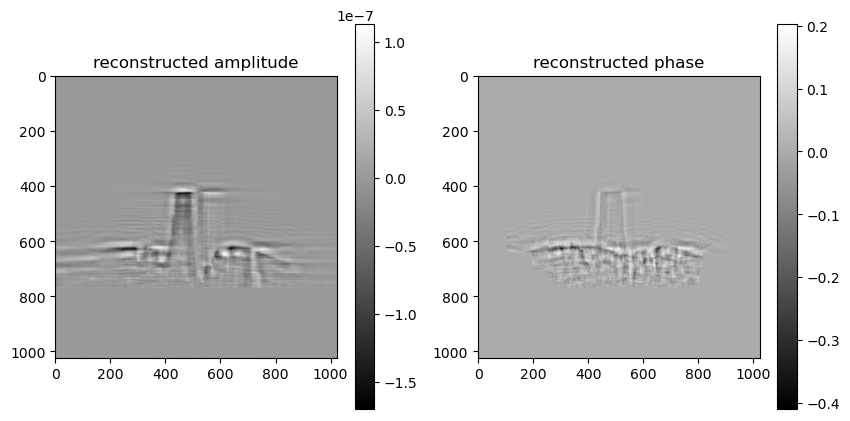

0/2048) rho=0.500000, 6.98e+08 1.17e+07 8.33e+04 4.16e+04, Sum: 7.10e+08


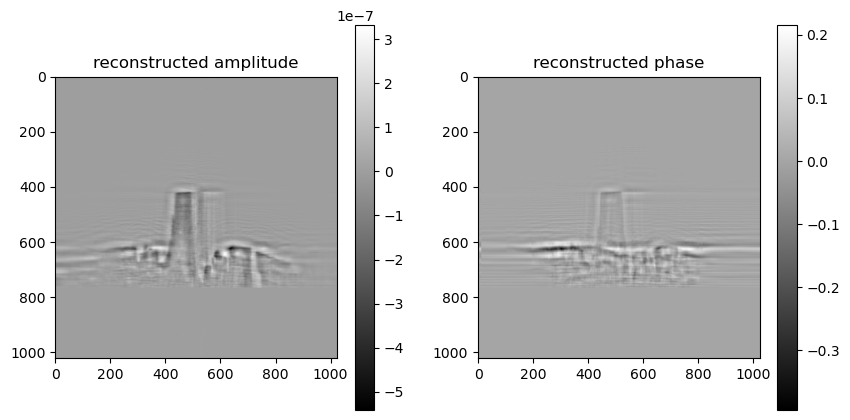

1/2048) rho=0.500000, 8.59e+08 1.19e+07 3.33e+04 2.19e+04, Sum: 8.71e+08


KeyboardInterrupt: 

In [17]:

theta = np.linspace(0,np.pi,1500,endpoint=False).astype('float32')
theta = np.ascontiguousarray(theta[::1500//ntheta])
tslv = holotomo.SolverTomo(theta, ntheta, ne, ne, pn, ne/2+12)

h = np.ones([ntheta,ne,ne],dtype='complex64')
lamd = np.zeros([ntheta,ne,ne],dtype='complex64')
rec = np.ones([ntheta,ne,ne],dtype='complex64')
rec_prb = rec_prb1.copy()
urec = np.zeros([ne,ne,ne],dtype='complex64')

# urec, rec, rec_prb = admm(pslv, pslv0, tslv, data, data_ref, h, rec, rec_prb, shifts,code,shifts_code, lamd, urec, 4, 1, 1,1,1)
urec, rec, rec_prb = admm(pslv, pslv0, tslv, data, data_ref, h, rec, rec_prb, shifts,code,shifts_code, lamd, urec, 16, 4, 2048,16,16)


In [ ]:

theta = np.linspace(0,np.pi,1500,endpoint=False).astype('float32')
theta = theta[::1500//ntheta]
tslv = holotomo.SolverTomo(theta, ntheta, ne, ne, pn*ne//n, center*ne//n+12)

xi = cp.array(pslv.logtomo(rec1))
ureg = cp.zeros([ne,ne,ne],dtype='complex64')
ureg = tslv.cg_tomo(xi,ureg,64,0.5)

dxchange.write_tiff(cp.imag(ureg).get(),      f'/data/vnikitin/modeling/zysset{flg}/uregim/r.tiff',overwrite=True)
dxchange.write_tiff(cp.imag(ureg[69]).get(), f'/data/vnikitin/modeling/zysset{flg}/uregim/o.tiff',overwrite=True)
dxchange.write_tiff(cp.real(ureg).get(),      f'/data/vnikitin/modeling/zysset{flg}/uregre/r.tiff',overwrite=True)
dxchange.write_tiff(cp.real(ureg[69]).get(), f'/data/vnikitin/modeling/zysset{flg}/uregre/o.tiff',overwrite=True)
dxchange.write_tiff(np.angle(rec1),   f'/data/vnikitin/modeling/zysset{flg}/psireg/r.tiff',overwrite=True)
dxchange.write_tiff(np.angle(rec1[0]),f'/data/vnikitin/modeling/zysset{flg}/psireg/o.tiff',overwrite=True)
            

h = cp.ones([ntheta,ne,ne],dtype='complex64')
lamd = cp.zeros([ntheta,ne,ne],dtype='complex64')
rec = cp.ones([ntheta,ne,ne],dtype='complex64')
rec_prb = cp.array(rec_prb0).copy()
urec = cp.zeros([ne,ne,ne],dtype='complex64')
data_gpu = cp.array(data)
data_ref_gpu = cp.array(data_ref)
shifts_gpu = cp.array(shifts)
code_gpu = cp.array(code)
shifts_code_gpu = cp.array(shifts_code)
    

urec, rec, rec_prb = admm_gpu(pslv, pslv0, tslv, data_gpu, data_ref_gpu, h, rec, rec_prb, shifts_gpu,code_gpu,shifts_code_gpu, lamd, urec, 16, 4, niter,16,16)